In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from TrialSolution import TrialSolution

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Example 7

$$\Delta\Psi(x, y)+\Psi(x, y)\frac{\partial}{\partial y}\Psi(x, y)=\sin(\pi x)\left(2-\pi^2y^2 +2y^3\sin(\pi x)\right)$$

With boundary conditions $\Psi(0,y)=0$, $\Psi(1, y)=0$, $\Psi(x, 0)=0$, and $\frac{\partial}{\partial y}\Psi(x, 1)=2\sin(\pi x)$.

The trial solution for this case is $\Psi(x, y)=A(x, y) + B(x, y)[N(x, y) - N(x, 1) - \frac{\partial N}{\partial y}(x, 1)]$ with $B(x)=x(1-x)y$ and $A(x, y)= 2y\sin(\pi x).$

In [2]:
n_samples = 10
X_train = np.linspace(0, 1, n_samples)
Y_train = np.linspace(0, 1, n_samples)
X_train, Y_train = np.meshgrid(X_train, Y_train)
X_train = X_train.flatten()
Y_train = Y_train.flatten()
samples_train = np.array([X_train, Y_train]).T

In [3]:
n_samples_test = 100
X_test = np.linspace(0, 1, n_samples_test)
Y_test = np.linspace(0, 1, n_samples_test)
X_test, Y_test = np.meshgrid(X_test, Y_test)
X_test = X_test.flatten()
Y_test = Y_test.flatten()
samples_test = np.array([X_test, Y_test]).T

In [4]:
bcs = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: X[:,1]**3},
        {'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: (tf.constant(1., dtype='float64', shape=(X.shape[0],1))+ X[:,1]**3)*tf.exp(tf.constant(-1., dtype='float64', shape=(X.shape[0],1)))},
        {'variable':1, 'value':0, 'type':'dirichlet',
        'function':lambda X: X[:,0]*tf.exp(-X[:,0])},
        {'variable':1, 'value':1, 'type':'dirichlet',
        'function':lambda X: (X[:,0]+tf.constant(1., dtype='float64', shape=(X.shape[0],1)))*tf.exp(-X[:,0])}]

In [5]:
def call(self, X):
  with tf.GradientTape() as tape:
    X = tf.convert_to_tensor(X)
    response = self.hidden_layer(X)
    response = self.output_layer(response)
    X1 = tf.concat([tf.reshape(X[:,0], shape=(X.shape[0], 1)),
                      tf.constant(1.0, dtype='float64', shape=(X.shape[0], 1))], axis=1)
    tape.watch(X1)
    response1 = self.hidden_layer(X1)
    response1 = self.output_layer(response1)
  der_resp1 = tape.gradient(response1, X1)
  der_resp1 = tf.reshape(der_resp1[:,1], shape=(response.shape[0],1))
  x = tf.reshape(X[:,0], shape=(response.shape[0],1))
  y = tf.reshape(X[:,1], shape=(response.shape[0],1))
  one = tf.constant(1., dtype='float64', shape=(response.shape[0],1))
  two = tf.constant(2., dtype='float64', shape=(response.shape[0],1))
  pi = tf.constant(np.pi, dtype='float64', shape=(response.shape[0],1))
  response -= response1
  response -= der_resp1
  response *= x*(one-x)*y
  response += y * two * tf.sin(pi * x)
  return response

In [6]:
ts = TrialSolution(conditions=bcs, n_i=2, n_h=10, n_o=1, equation_type='PDE', call_method=call)

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(\Delta\Psi(x_i, N(x_i))-\sin(\pi x)\left(2-\pi^2y^2\right) \right)^2$$
And the Laplace operator term acting on the trial solution becomes:
$$\Delta\Psi(x_i, N(x_i))=\Delta A(x,y) + \Delta \left(x(1-x)y\left[N(x, y) - N(x, 1) - \frac{\partial N}{\partial y}(x, 1)\right]\right)$$
$$=-2\pi^2y\sin(\pi x) +2x(1-x)\frac{\partial N}{\partial y}(x, y) +x(1-x)y\frac{\partial^2 N}{\partial y^2}(x, y)- 2y \left[N(x, y) - N(x, 1) - \frac{\partial N}{\partial y}(x, 1)\right] + 2y(1-2x) \left[\frac{\partial N}{\partial x}(x, y) - \frac{\partial N}{\partial x}(x, 1) - \frac{\partial^2 N}{\partial x\partial y}(x, 1)\right] +x(1-x)y\left[\frac{\partial^2 N}{\partial x^2}(x, y) - \frac{\partial^2 N}{\partial x^2}(x, 1) - \frac{\partial^3 N}{\partial x^2\partial y}(x, 1)\right]$$

In [7]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
      inputs = tf.convert_to_tensor(inputs)
      tape.watch(inputs)
      tape2.watch(inputs)
      response = network(inputs)  
    grads = tape.gradient(response, inputs)
  laplace = tape2.gradient(grads, inputs)
#   print(grads)
#   print(laplace)
  two = tf.constant(2, dtype='float64')
  pi = tf.constant(np.pi, dtype='float64')
  loss = tf.square(laplace[:,0] + laplace[:,1] + response * grads[:,1]
                   - tf.sin(pi*inputs[:,0])*(two  - pi**2*inputs[:,1]**2 + two * inputs[:,1]**3*tf.sin(pi*inputs[:,0])))
  return loss

### Training

In [8]:
ts.train(X=samples_train, diff_loss=diff_loss, epochs=10000, message_frequency=1000, optimizer_name='SGD', learning_rate=0.0001)

Epoch: 1000 Loss: 154.3770294189453
Epoch: 2000 Loss: 137.46371459960938
Epoch: 3000 Loss: 131.82594299316406
Epoch: 4000 Loss: 129.00247192382812
Epoch: 5000 Loss: 127.30693817138672
Epoch: 6000 Loss: 126.17658233642578
Epoch: 7000 Loss: 125.44989013671875
Epoch: 8000 Loss: 124.8342514038086
Epoch: 9000 Loss: 124.35542297363281
Epoch: 10000 Loss: 123.97235870361328


### Plotting the results 

The numerical solution.

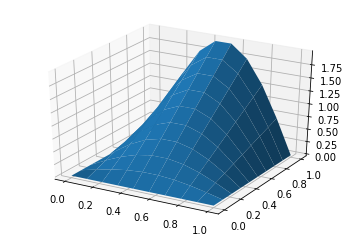

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples_train.shape[0]))
Ze5sol = tf.reshape(ts(samples_train), shape=(samples_train.shape[0],)).numpy()
ax.plot_surface(X=samples_train[:,0].reshape((new_shape, new_shape)), Y=samples_train[:,1].reshape((new_shape, new_shape)), Z=Ze5sol.reshape((new_shape, new_shape)), label='Numerical - Training')
plt.show()

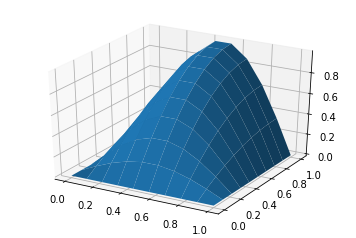

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze5anal = np.sin(np.pi*samples_train[:,0])*samples_train[:,1]**2
Ze5diff = Ze5sol - Ze5anal
ax.plot_surface(X=samples_train[:,0].reshape((new_shape, new_shape)), Y=samples_train[:,1].reshape((new_shape, new_shape)), Z=Ze5diff.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [11]:
np.abs(Ze5diff**2).mean()

0.2384979401885228

In [12]:
np.max(np.abs(Ze5diff))

0.9848077530105747

The test error.

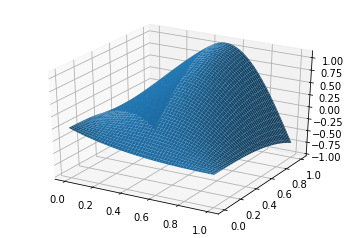

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape_test = int(np.sqrt(samples_test.shape[0]))
Ze5sol_test = tf.reshape(ts(samples_test), shape=(samples_test.shape[0],)).numpy()
Ze5anal_test = (samples_test[:,0] + samples_test[:,1]**3) * np.exp(-samples_test[:, 0])
Ze5diff_test = (Ze5sol_test - Ze5anal_test)
ax.plot_surface(X=samples_test[:,0].reshape((new_shape_test, new_shape_test)),
                Y=samples_test[:,1].reshape((new_shape_test, new_shape_test)),
                Z=Ze5diff_test.reshape((new_shape_test, new_shape_test)), label='Training error')
# plt.legend()
plt.show()

The mean absolute error (*MAE*) on the trianing set.

In [16]:
np.abs(Ze5diff_test).mean()

0.3563682234078361

The maximal absolute error on the trianing set.

In [17]:
np.max(np.abs(Ze5diff_test))

1.0925679039951506

Conclusion is that the parametrization of the trial solution is not working or there is some missunderstanding of the concept presented in the paper.